# Background
# Online Face detection and Recognition system
## Requirements: 
### 1. Able to create new user accounts with GUI
### 2. Detect and recognize a person with a live camera

# Workflow: User Registration, Model Training, and Login

This workflow involves three main steps: 
1. **User Registration:** Capture images of the user's face to create a dataset.
2. **Model Training:** Train a machine learning model (Support Vector Machine) on the collected face images.
3. **Login:** Authenticate users based on their facial features.

## Step 1: Setup Environment

In [7]:
!pip install numpy opencv-python scikit-learn pandas matplotlib

  Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl (38.6 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autodistill-grounding-dino 0.1.3 requires rf-groundingdino, which is not installed.
autodistill-grounding-dino 0.1.3 requires rf-segment-anything, which is not installed.
autodistill-grounding-dino 0.1.3 requires torch, which is not installed.


In [8]:
!pip install opencv-python-headless scikit-learn numpy

## Step 2: Import Libraries

In [41]:
import tkinter as tk
from tkinter import simpledialog, messagebox
import cv2
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import time

## Step 3: GUI for User Interaction


In [42]:
# Setting up file paths for user images, users CSV, model, PCA, and label dictionary
user_images_dir = 'user_images'
users_csv = 'users.csv'
model_filename = 'svm_face_model.pkl'
pca_filename = 'pca.pkl'
label_dict_filename = 'label_dict.csv'

# Creating user images directory if it doesn't exist
if not os.path.exists(user_images_dir):
    os.makedirs(user_images_dir)

# Ensuring the users CSV exists, if not, creating it with headers
if not os.path.exists(users_csv):
    with open(users_csv, 'w') as file:
        file.write('username,path\n')

# Function to capture images for a new user
import matplotlib.pyplot as plt

def capture_images(username):
    cap = cv2.VideoCapture(0)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    count = 0

    user_dir = os.path.join(user_images_dir, username)
    if not os.path.exists(user_dir):
        os.makedirs(user_dir)

    print("Press 's' to start capturing images...")

    fig, ax = plt.subplots()
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)

        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
            face = gray[y:y+h, x:x+w]
            face = cv2.resize(face, (100, 100))
            if count < 100:
                cv2.imwrite(os.path.join(user_dir, f'{count}.png'), face)
                count += 1
                print(f"Captured {count}/100 images")

        ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.draw()
        plt.pause(0.01)
        ax.clear()

        if count >= 100:
            print("Finished capturing images.")
            break

    cap.release()
    plt.close()

    with open(users_csv, 'a') as file:
        file.write(f'{username},{user_dir}\n')



# Function to train the model
def train_model():
    X, y, label_dict = load_images_and_labels()

    if len(set(y)) <= 1:
        print("Error: Need at least two different users to train the model.")
        return

    pca = PCA(n_components=min(100, len(X))).fit(X)
    X_pca = pca.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25, random_state=42)

    clf = SVC(kernel='linear', probability=True)
    clf.fit(X_train, y_train)

    joblib.dump(clf, model_filename)
    joblib.dump(pca, pca_filename)
    pd.DataFrame.from_dict(label_dict, orient='index').to_csv(label_dict_filename, header=False)

    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))


# Function to load images and labels
def load_images_and_labels():
    images = []  # List to store images
    labels = []  # List to store labels
    label_dict = {}  # Dictionary to store label-user mapping
    users_df = pd.read_csv(users_csv)  # Reading users CSV
    
    for index, row in users_df.iterrows():
        user_folder = row['path']  # Path to user's image directory
        username = row['username']  # User's name
        label = index  # Label for the user
        label_dict[label] = username  # Mapping label to username
        
        for image_file in os.listdir(user_folder):
            image_path = os.path.join(user_folder, image_file)  # Path to the image file
            image = cv2.imread(image_path, 0)  # Reading image in grayscale
            images.append(image)  # Appending image to list
            labels.append(label)  # Appending label to list
    
    X = np.array(images).reshape(len(images), -1)  # Converting image list to numpy array
    y = np.array(labels)  # Converting label list to numpy array
    return X, y, label_dict  # Returning images, labels, and label dictionary

# Function to login using Face ID
def login_user():
    username = simpledialog.askstring("Login", "Enter username to login:")
    if not username:
        messagebox.showinfo("Login", "No username entered.")
        return

    clf = joblib.load(model_filename)
    pca = joblib.load(pca_filename)
    label_dict = pd.read_csv(label_dict_filename, header=None, index_col=0).squeeze("columns").to_dict()

    target_label = None
    for label, user in label_dict.items():
        if user == username:
            target_label = label
            break

    if target_label is None:
        messagebox.showinfo("Login", f"Username '{username}' not found in trained model.")
        return

    cap = cv2.VideoCapture(0)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    detected = False
    start_time = time.time()

    print("Attempting to log in...")

    fig, ax = plt.subplots()
    while time.time() - start_time < 5:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)

        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
            face = gray[y:y+h, x:x+w]
            face = cv2.resize(face, (100, 100)).reshape(1, -1)
            face_pca = pca.transform(face)

            pred = clf.predict(face_pca)
            prob = clf.predict_proba(face_pca).max()

            if pred[0] == target_label and prob > 0.90:
                print(f'{username} detected with confidence {prob*100:.2f}%')
                detected = True
                break
            else:
                print(f'{username} not detected')

        ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.draw()
        plt.pause(0.01)
        ax.clear()

        if detected:
            break

    cap.release()
    plt.close()

    if detected:
        messagebox.showinfo("Login Successful", f"{username} logged in.")
    else:
        messagebox.showinfo("Login Failed", f"{username} could not be logged in.")


## Step 4: Start GUI

Press 's' to start capturing images...
Captured 1/100 images


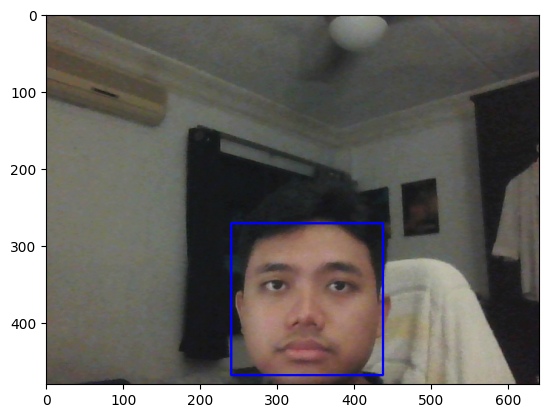

Captured 2/100 images


<Figure size 640x480 with 0 Axes>

Captured 3/100 images


<Figure size 640x480 with 0 Axes>

Captured 4/100 images


<Figure size 640x480 with 0 Axes>

Captured 5/100 images


<Figure size 640x480 with 0 Axes>

Captured 6/100 images


<Figure size 640x480 with 0 Axes>

Captured 7/100 images


<Figure size 640x480 with 0 Axes>

Captured 8/100 images


<Figure size 640x480 with 0 Axes>

Captured 9/100 images


<Figure size 640x480 with 0 Axes>

Captured 10/100 images


<Figure size 640x480 with 0 Axes>

Captured 11/100 images


<Figure size 640x480 with 0 Axes>

Captured 12/100 images


<Figure size 640x480 with 0 Axes>

Captured 13/100 images


<Figure size 640x480 with 0 Axes>

Captured 14/100 images


<Figure size 640x480 with 0 Axes>

Captured 15/100 images


<Figure size 640x480 with 0 Axes>

Captured 16/100 images


<Figure size 640x480 with 0 Axes>

Captured 17/100 images


<Figure size 640x480 with 0 Axes>

Captured 18/100 images


<Figure size 640x480 with 0 Axes>

Captured 19/100 images


<Figure size 640x480 with 0 Axes>

Captured 20/100 images


<Figure size 640x480 with 0 Axes>

Captured 21/100 images


<Figure size 640x480 with 0 Axes>

Captured 22/100 images


<Figure size 640x480 with 0 Axes>

Captured 23/100 images


<Figure size 640x480 with 0 Axes>

Captured 24/100 images


<Figure size 640x480 with 0 Axes>

Captured 25/100 images


<Figure size 640x480 with 0 Axes>

Captured 26/100 images


<Figure size 640x480 with 0 Axes>

Captured 27/100 images


<Figure size 640x480 with 0 Axes>

Captured 28/100 images


<Figure size 640x480 with 0 Axes>

Captured 29/100 images


<Figure size 640x480 with 0 Axes>

Captured 30/100 images


<Figure size 640x480 with 0 Axes>

Captured 31/100 images


<Figure size 640x480 with 0 Axes>

Captured 32/100 images


<Figure size 640x480 with 0 Axes>

Captured 33/100 images


<Figure size 640x480 with 0 Axes>

Captured 34/100 images


<Figure size 640x480 with 0 Axes>

Captured 35/100 images


<Figure size 640x480 with 0 Axes>

Captured 36/100 images


<Figure size 640x480 with 0 Axes>

Captured 37/100 images


<Figure size 640x480 with 0 Axes>

Captured 38/100 images


<Figure size 640x480 with 0 Axes>

Captured 39/100 images


<Figure size 640x480 with 0 Axes>

Captured 40/100 images


<Figure size 640x480 with 0 Axes>

Captured 41/100 images


<Figure size 640x480 with 0 Axes>

Captured 42/100 images


<Figure size 640x480 with 0 Axes>

Captured 43/100 images


<Figure size 640x480 with 0 Axes>

Captured 44/100 images


<Figure size 640x480 with 0 Axes>

Captured 45/100 images


<Figure size 640x480 with 0 Axes>

Captured 46/100 images


<Figure size 640x480 with 0 Axes>

Captured 47/100 images


<Figure size 640x480 with 0 Axes>

Captured 48/100 images


<Figure size 640x480 with 0 Axes>

Captured 49/100 images


<Figure size 640x480 with 0 Axes>

Captured 50/100 images


<Figure size 640x480 with 0 Axes>

Captured 51/100 images


<Figure size 640x480 with 0 Axes>

Captured 52/100 images


<Figure size 640x480 with 0 Axes>

Captured 53/100 images


<Figure size 640x480 with 0 Axes>

Captured 54/100 images


<Figure size 640x480 with 0 Axes>

Captured 55/100 images


<Figure size 640x480 with 0 Axes>

Captured 56/100 images


<Figure size 640x480 with 0 Axes>

Captured 57/100 images


<Figure size 640x480 with 0 Axes>

Captured 58/100 images


<Figure size 640x480 with 0 Axes>

Captured 59/100 images


<Figure size 640x480 with 0 Axes>

Captured 60/100 images


<Figure size 640x480 with 0 Axes>

Captured 61/100 images


<Figure size 640x480 with 0 Axes>

Captured 62/100 images


<Figure size 640x480 with 0 Axes>

Captured 63/100 images


<Figure size 640x480 with 0 Axes>

Captured 64/100 images


<Figure size 640x480 with 0 Axes>

Captured 65/100 images


<Figure size 640x480 with 0 Axes>

Captured 66/100 images


<Figure size 640x480 with 0 Axes>

Captured 67/100 images


<Figure size 640x480 with 0 Axes>

Captured 68/100 images


<Figure size 640x480 with 0 Axes>

Captured 69/100 images


<Figure size 640x480 with 0 Axes>

Captured 70/100 images


<Figure size 640x480 with 0 Axes>

Captured 71/100 images


<Figure size 640x480 with 0 Axes>

Captured 72/100 images


<Figure size 640x480 with 0 Axes>

Captured 73/100 images


<Figure size 640x480 with 0 Axes>

Captured 74/100 images


<Figure size 640x480 with 0 Axes>

Captured 75/100 images


<Figure size 640x480 with 0 Axes>

Captured 76/100 images


<Figure size 640x480 with 0 Axes>

Captured 77/100 images


<Figure size 640x480 with 0 Axes>

Captured 78/100 images


<Figure size 640x480 with 0 Axes>

Captured 79/100 images


<Figure size 640x480 with 0 Axes>

Captured 80/100 images


<Figure size 640x480 with 0 Axes>

Captured 81/100 images


<Figure size 640x480 with 0 Axes>

Captured 82/100 images


<Figure size 640x480 with 0 Axes>

Captured 83/100 images


<Figure size 640x480 with 0 Axes>

Captured 84/100 images


<Figure size 640x480 with 0 Axes>

Captured 85/100 images


<Figure size 640x480 with 0 Axes>

Captured 86/100 images


<Figure size 640x480 with 0 Axes>

Captured 87/100 images


<Figure size 640x480 with 0 Axes>

Captured 88/100 images


<Figure size 640x480 with 0 Axes>

Captured 89/100 images


<Figure size 640x480 with 0 Axes>

Captured 90/100 images


<Figure size 640x480 with 0 Axes>

Captured 91/100 images


<Figure size 640x480 with 0 Axes>

Captured 92/100 images


<Figure size 640x480 with 0 Axes>

Captured 93/100 images


<Figure size 640x480 with 0 Axes>

Captured 94/100 images


<Figure size 640x480 with 0 Axes>

Captured 95/100 images


<Figure size 640x480 with 0 Axes>

Captured 96/100 images


<Figure size 640x480 with 0 Axes>

Captured 97/100 images


<Figure size 640x480 with 0 Axes>

Captured 98/100 images


<Figure size 640x480 with 0 Axes>

Captured 99/100 images


<Figure size 640x480 with 0 Axes>

Captured 100/100 images


<Figure size 640x480 with 0 Axes>

Finished capturing images.
Press 's' to start capturing images...
Captured 1/100 images


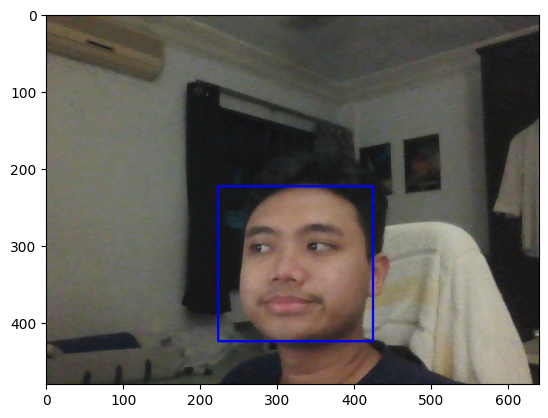

Captured 2/100 images


<Figure size 640x480 with 0 Axes>

Captured 3/100 images


<Figure size 640x480 with 0 Axes>

Captured 4/100 images


<Figure size 640x480 with 0 Axes>

Captured 5/100 images


<Figure size 640x480 with 0 Axes>

Captured 6/100 images


<Figure size 640x480 with 0 Axes>

Captured 7/100 images


<Figure size 640x480 with 0 Axes>

Captured 8/100 images


<Figure size 640x480 with 0 Axes>

Captured 9/100 images


<Figure size 640x480 with 0 Axes>

Captured 10/100 images


<Figure size 640x480 with 0 Axes>

Captured 11/100 images


<Figure size 640x480 with 0 Axes>

Captured 12/100 images


<Figure size 640x480 with 0 Axes>

Captured 13/100 images


<Figure size 640x480 with 0 Axes>

Captured 14/100 images


<Figure size 640x480 with 0 Axes>

Captured 15/100 images


<Figure size 640x480 with 0 Axes>

Captured 16/100 images


<Figure size 640x480 with 0 Axes>

Captured 17/100 images


<Figure size 640x480 with 0 Axes>

Captured 18/100 images


<Figure size 640x480 with 0 Axes>

Captured 19/100 images


<Figure size 640x480 with 0 Axes>

Captured 20/100 images


<Figure size 640x480 with 0 Axes>

Captured 21/100 images


<Figure size 640x480 with 0 Axes>

Captured 22/100 images


<Figure size 640x480 with 0 Axes>

Captured 23/100 images


<Figure size 640x480 with 0 Axes>

Captured 24/100 images


<Figure size 640x480 with 0 Axes>

Captured 25/100 images


<Figure size 640x480 with 0 Axes>

Captured 26/100 images


<Figure size 640x480 with 0 Axes>

Captured 27/100 images


<Figure size 640x480 with 0 Axes>

Captured 28/100 images


<Figure size 640x480 with 0 Axes>

Captured 29/100 images


<Figure size 640x480 with 0 Axes>

Captured 30/100 images


<Figure size 640x480 with 0 Axes>

Captured 31/100 images


<Figure size 640x480 with 0 Axes>

Captured 32/100 images


<Figure size 640x480 with 0 Axes>

Captured 33/100 images


<Figure size 640x480 with 0 Axes>

Captured 34/100 images


<Figure size 640x480 with 0 Axes>

Captured 35/100 images


<Figure size 640x480 with 0 Axes>

Captured 36/100 images


<Figure size 640x480 with 0 Axes>

Captured 37/100 images


<Figure size 640x480 with 0 Axes>

Captured 38/100 images


<Figure size 640x480 with 0 Axes>

Captured 39/100 images


<Figure size 640x480 with 0 Axes>

Captured 40/100 images


<Figure size 640x480 with 0 Axes>

Captured 41/100 images


<Figure size 640x480 with 0 Axes>

Captured 42/100 images


<Figure size 640x480 with 0 Axes>

Captured 43/100 images


<Figure size 640x480 with 0 Axes>

Captured 44/100 images


<Figure size 640x480 with 0 Axes>

Captured 45/100 images


<Figure size 640x480 with 0 Axes>

Captured 46/100 images


<Figure size 640x480 with 0 Axes>

Captured 47/100 images


<Figure size 640x480 with 0 Axes>

Captured 48/100 images


<Figure size 640x480 with 0 Axes>

Captured 49/100 images


<Figure size 640x480 with 0 Axes>

Captured 50/100 images


<Figure size 640x480 with 0 Axes>

Captured 51/100 images


<Figure size 640x480 with 0 Axes>

Captured 52/100 images


<Figure size 640x480 with 0 Axes>

Captured 53/100 images


<Figure size 640x480 with 0 Axes>

Captured 54/100 images


<Figure size 640x480 with 0 Axes>

Captured 55/100 images


<Figure size 640x480 with 0 Axes>

Captured 56/100 images


<Figure size 640x480 with 0 Axes>

Captured 57/100 images


<Figure size 640x480 with 0 Axes>

Captured 58/100 images


<Figure size 640x480 with 0 Axes>

Captured 59/100 images


<Figure size 640x480 with 0 Axes>

Captured 60/100 images


<Figure size 640x480 with 0 Axes>

Captured 61/100 images


<Figure size 640x480 with 0 Axes>

Captured 62/100 images


<Figure size 640x480 with 0 Axes>

Captured 63/100 images


<Figure size 640x480 with 0 Axes>

Captured 64/100 images


<Figure size 640x480 with 0 Axes>

Captured 65/100 images


<Figure size 640x480 with 0 Axes>

Captured 66/100 images


<Figure size 640x480 with 0 Axes>

Captured 67/100 images


<Figure size 640x480 with 0 Axes>

Captured 68/100 images


<Figure size 640x480 with 0 Axes>

Captured 69/100 images


<Figure size 640x480 with 0 Axes>

Captured 70/100 images


<Figure size 640x480 with 0 Axes>

Captured 71/100 images


<Figure size 640x480 with 0 Axes>

Captured 72/100 images


<Figure size 640x480 with 0 Axes>

Captured 73/100 images


<Figure size 640x480 with 0 Axes>

Captured 74/100 images


<Figure size 640x480 with 0 Axes>

Captured 75/100 images


<Figure size 640x480 with 0 Axes>

Captured 76/100 images


<Figure size 640x480 with 0 Axes>

Captured 77/100 images


<Figure size 640x480 with 0 Axes>

Captured 78/100 images


<Figure size 640x480 with 0 Axes>

Captured 79/100 images


<Figure size 640x480 with 0 Axes>

Captured 80/100 images


<Figure size 640x480 with 0 Axes>

Captured 81/100 images


<Figure size 640x480 with 0 Axes>

Captured 82/100 images


<Figure size 640x480 with 0 Axes>

Captured 83/100 images


<Figure size 640x480 with 0 Axes>

Captured 84/100 images


<Figure size 640x480 with 0 Axes>

Captured 85/100 images


<Figure size 640x480 with 0 Axes>

Captured 86/100 images


<Figure size 640x480 with 0 Axes>

Captured 87/100 images


<Figure size 640x480 with 0 Axes>

Captured 88/100 images


<Figure size 640x480 with 0 Axes>

Captured 89/100 images


<Figure size 640x480 with 0 Axes>

Captured 90/100 images


<Figure size 640x480 with 0 Axes>

Captured 91/100 images


<Figure size 640x480 with 0 Axes>

Captured 92/100 images


<Figure size 640x480 with 0 Axes>

Captured 93/100 images


<Figure size 640x480 with 0 Axes>

Captured 94/100 images


<Figure size 640x480 with 0 Axes>

Captured 95/100 images


<Figure size 640x480 with 0 Axes>

Captured 96/100 images


<Figure size 640x480 with 0 Axes>

Captured 97/100 images


<Figure size 640x480 with 0 Axes>

Captured 98/100 images


<Figure size 640x480 with 0 Axes>

Captured 99/100 images


<Figure size 640x480 with 0 Axes>

Captured 100/100 images


<Figure size 640x480 with 0 Axes>

Finished capturing images.
Press 's' to start capturing images...
Captured 1/100 images


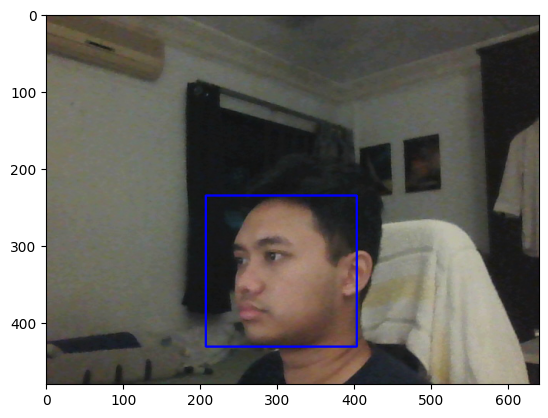

Captured 2/100 images
Captured 3/100 images


<Figure size 640x480 with 0 Axes>

Captured 4/100 images


<Figure size 640x480 with 0 Axes>

Captured 5/100 images


<Figure size 640x480 with 0 Axes>

Captured 6/100 images


<Figure size 640x480 with 0 Axes>

Captured 7/100 images


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Captured 8/100 images


<Figure size 640x480 with 0 Axes>

Captured 9/100 images


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Captured 10/100 images


<Figure size 640x480 with 0 Axes>

Captured 11/100 images


<Figure size 640x480 with 0 Axes>

Captured 12/100 images


<Figure size 640x480 with 0 Axes>

Captured 13/100 images
Captured 14/100 images


<Figure size 640x480 with 0 Axes>

Captured 15/100 images


<Figure size 640x480 with 0 Axes>

Captured 16/100 images


<Figure size 640x480 with 0 Axes>

Captured 17/100 images


<Figure size 640x480 with 0 Axes>

Captured 18/100 images


<Figure size 640x480 with 0 Axes>

Captured 19/100 images
Captured 20/100 images


<Figure size 640x480 with 0 Axes>

Captured 21/100 images
Captured 22/100 images


<Figure size 640x480 with 0 Axes>

Captured 23/100 images


<Figure size 640x480 with 0 Axes>

Captured 24/100 images


<Figure size 640x480 with 0 Axes>

Captured 25/100 images


<Figure size 640x480 with 0 Axes>

Captured 26/100 images


<Figure size 640x480 with 0 Axes>

Captured 27/100 images
Captured 28/100 images


<Figure size 640x480 with 0 Axes>

Captured 29/100 images


<Figure size 640x480 with 0 Axes>

Captured 30/100 images


<Figure size 640x480 with 0 Axes>

Captured 31/100 images


<Figure size 640x480 with 0 Axes>

Captured 32/100 images


<Figure size 640x480 with 0 Axes>

Captured 33/100 images


<Figure size 640x480 with 0 Axes>

Captured 34/100 images


<Figure size 640x480 with 0 Axes>

Captured 35/100 images


<Figure size 640x480 with 0 Axes>

Captured 36/100 images


<Figure size 640x480 with 0 Axes>

Captured 37/100 images


<Figure size 640x480 with 0 Axes>

Captured 38/100 images


<Figure size 640x480 with 0 Axes>

Captured 39/100 images


<Figure size 640x480 with 0 Axes>

Captured 40/100 images


<Figure size 640x480 with 0 Axes>

Captured 41/100 images


<Figure size 640x480 with 0 Axes>

Captured 42/100 images


<Figure size 640x480 with 0 Axes>

Captured 43/100 images


<Figure size 640x480 with 0 Axes>

Captured 44/100 images


<Figure size 640x480 with 0 Axes>

Captured 45/100 images


<Figure size 640x480 with 0 Axes>

Captured 46/100 images


<Figure size 640x480 with 0 Axes>

Captured 47/100 images


<Figure size 640x480 with 0 Axes>

Captured 48/100 images


<Figure size 640x480 with 0 Axes>

Captured 49/100 images


<Figure size 640x480 with 0 Axes>

Captured 50/100 images


<Figure size 640x480 with 0 Axes>

Captured 51/100 images


<Figure size 640x480 with 0 Axes>

Captured 52/100 images


<Figure size 640x480 with 0 Axes>

Captured 53/100 images


<Figure size 640x480 with 0 Axes>

Captured 54/100 images


<Figure size 640x480 with 0 Axes>

Captured 55/100 images


<Figure size 640x480 with 0 Axes>

Captured 56/100 images


<Figure size 640x480 with 0 Axes>

Captured 57/100 images


<Figure size 640x480 with 0 Axes>

Captured 58/100 images


<Figure size 640x480 with 0 Axes>

Captured 59/100 images


<Figure size 640x480 with 0 Axes>

Captured 60/100 images


<Figure size 640x480 with 0 Axes>

Captured 61/100 images


<Figure size 640x480 with 0 Axes>

Captured 62/100 images


<Figure size 640x480 with 0 Axes>

Captured 63/100 images


<Figure size 640x480 with 0 Axes>

Captured 64/100 images


<Figure size 640x480 with 0 Axes>

Captured 65/100 images


<Figure size 640x480 with 0 Axes>

Captured 66/100 images


<Figure size 640x480 with 0 Axes>

Captured 67/100 images


<Figure size 640x480 with 0 Axes>

Captured 68/100 images


<Figure size 640x480 with 0 Axes>

Captured 69/100 images


<Figure size 640x480 with 0 Axes>

Captured 70/100 images


<Figure size 640x480 with 0 Axes>

Captured 71/100 images


<Figure size 640x480 with 0 Axes>

Captured 72/100 images


<Figure size 640x480 with 0 Axes>

Captured 73/100 images


<Figure size 640x480 with 0 Axes>

Captured 74/100 images


<Figure size 640x480 with 0 Axes>

Captured 75/100 images


<Figure size 640x480 with 0 Axes>

Captured 76/100 images


<Figure size 640x480 with 0 Axes>

Captured 77/100 images


<Figure size 640x480 with 0 Axes>

Captured 78/100 images


<Figure size 640x480 with 0 Axes>

Captured 79/100 images


<Figure size 640x480 with 0 Axes>

Captured 80/100 images


<Figure size 640x480 with 0 Axes>

Captured 81/100 images


<Figure size 640x480 with 0 Axes>

Captured 82/100 images


<Figure size 640x480 with 0 Axes>

Captured 83/100 images


<Figure size 640x480 with 0 Axes>

Captured 84/100 images


<Figure size 640x480 with 0 Axes>

Captured 85/100 images


<Figure size 640x480 with 0 Axes>

Captured 86/100 images


<Figure size 640x480 with 0 Axes>

Captured 87/100 images


<Figure size 640x480 with 0 Axes>

Captured 88/100 images


<Figure size 640x480 with 0 Axes>

Captured 89/100 images


<Figure size 640x480 with 0 Axes>

Captured 90/100 images
Captured 91/100 images


<Figure size 640x480 with 0 Axes>

Captured 92/100 images


<Figure size 640x480 with 0 Axes>

Captured 93/100 images


<Figure size 640x480 with 0 Axes>

Captured 94/100 images


<Figure size 640x480 with 0 Axes>

Captured 95/100 images


<Figure size 640x480 with 0 Axes>

Captured 96/100 images


<Figure size 640x480 with 0 Axes>

Captured 97/100 images


<Figure size 640x480 with 0 Axes>

Captured 98/100 images


<Figure size 640x480 with 0 Axes>

Captured 99/100 images


<Figure size 640x480 with 0 Axes>

Captured 100/100 images


<Figure size 640x480 with 0 Axes>

Finished capturing images.
Press 's' to start capturing images...
Captured 1/100 images


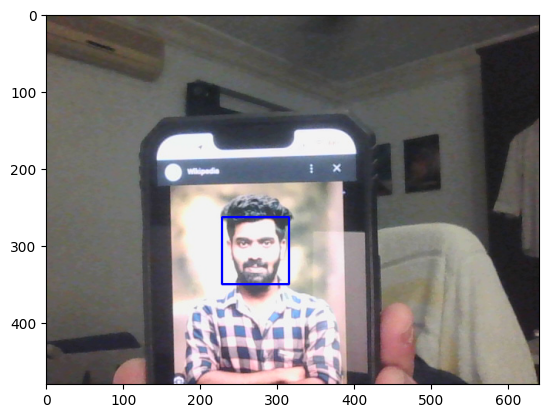

Captured 2/100 images


<Figure size 640x480 with 0 Axes>

Captured 3/100 images


<Figure size 640x480 with 0 Axes>

Captured 4/100 images


<Figure size 640x480 with 0 Axes>

Captured 5/100 images


<Figure size 640x480 with 0 Axes>

Captured 6/100 images


<Figure size 640x480 with 0 Axes>

Captured 7/100 images


<Figure size 640x480 with 0 Axes>

Captured 8/100 images


<Figure size 640x480 with 0 Axes>

Captured 9/100 images


<Figure size 640x480 with 0 Axes>

Captured 10/100 images


<Figure size 640x480 with 0 Axes>

Captured 11/100 images


<Figure size 640x480 with 0 Axes>

Captured 12/100 images


<Figure size 640x480 with 0 Axes>

Captured 13/100 images


<Figure size 640x480 with 0 Axes>

Captured 14/100 images


<Figure size 640x480 with 0 Axes>

Captured 15/100 images


<Figure size 640x480 with 0 Axes>

Captured 16/100 images


<Figure size 640x480 with 0 Axes>

Captured 17/100 images


<Figure size 640x480 with 0 Axes>

Captured 18/100 images


<Figure size 640x480 with 0 Axes>

Captured 19/100 images


<Figure size 640x480 with 0 Axes>

Captured 20/100 images


<Figure size 640x480 with 0 Axes>

Captured 21/100 images


<Figure size 640x480 with 0 Axes>

Captured 22/100 images


<Figure size 640x480 with 0 Axes>

Captured 23/100 images


<Figure size 640x480 with 0 Axes>

Captured 24/100 images


<Figure size 640x480 with 0 Axes>

Captured 25/100 images


<Figure size 640x480 with 0 Axes>

Captured 26/100 images


<Figure size 640x480 with 0 Axes>

Captured 27/100 images


<Figure size 640x480 with 0 Axes>

Captured 28/100 images


<Figure size 640x480 with 0 Axes>

Captured 29/100 images


<Figure size 640x480 with 0 Axes>

Captured 30/100 images


<Figure size 640x480 with 0 Axes>

Captured 31/100 images


<Figure size 640x480 with 0 Axes>

Captured 32/100 images


<Figure size 640x480 with 0 Axes>

Captured 33/100 images


<Figure size 640x480 with 0 Axes>

Captured 34/100 images


<Figure size 640x480 with 0 Axes>

Captured 35/100 images


<Figure size 640x480 with 0 Axes>

Captured 36/100 images


<Figure size 640x480 with 0 Axes>

Captured 37/100 images


<Figure size 640x480 with 0 Axes>

Captured 38/100 images


<Figure size 640x480 with 0 Axes>

Captured 39/100 images


<Figure size 640x480 with 0 Axes>

Captured 40/100 images


<Figure size 640x480 with 0 Axes>

Captured 41/100 images


<Figure size 640x480 with 0 Axes>

Captured 42/100 images


<Figure size 640x480 with 0 Axes>

Captured 43/100 images


<Figure size 640x480 with 0 Axes>

Captured 44/100 images


<Figure size 640x480 with 0 Axes>

Captured 45/100 images


<Figure size 640x480 with 0 Axes>

Captured 46/100 images


<Figure size 640x480 with 0 Axes>

Captured 47/100 images


<Figure size 640x480 with 0 Axes>

Captured 48/100 images


<Figure size 640x480 with 0 Axes>

Captured 49/100 images


<Figure size 640x480 with 0 Axes>

Captured 50/100 images


<Figure size 640x480 with 0 Axes>

Captured 51/100 images


<Figure size 640x480 with 0 Axes>

Captured 52/100 images


<Figure size 640x480 with 0 Axes>

Captured 53/100 images


<Figure size 640x480 with 0 Axes>

Captured 54/100 images


<Figure size 640x480 with 0 Axes>

Captured 55/100 images


<Figure size 640x480 with 0 Axes>

Captured 56/100 images


<Figure size 640x480 with 0 Axes>

Captured 57/100 images


<Figure size 640x480 with 0 Axes>

Captured 58/100 images


<Figure size 640x480 with 0 Axes>

Captured 59/100 images


<Figure size 640x480 with 0 Axes>

Captured 60/100 images


<Figure size 640x480 with 0 Axes>

Captured 61/100 images


<Figure size 640x480 with 0 Axes>

Captured 62/100 images


<Figure size 640x480 with 0 Axes>

Captured 63/100 images


<Figure size 640x480 with 0 Axes>

Captured 64/100 images


<Figure size 640x480 with 0 Axes>

Captured 65/100 images


<Figure size 640x480 with 0 Axes>

Captured 66/100 images


<Figure size 640x480 with 0 Axes>

Captured 67/100 images


<Figure size 640x480 with 0 Axes>

Captured 68/100 images


<Figure size 640x480 with 0 Axes>

Captured 69/100 images


<Figure size 640x480 with 0 Axes>

Captured 70/100 images


<Figure size 640x480 with 0 Axes>

Captured 71/100 images


<Figure size 640x480 with 0 Axes>

Captured 72/100 images


<Figure size 640x480 with 0 Axes>

Captured 73/100 images


<Figure size 640x480 with 0 Axes>

Captured 74/100 images


<Figure size 640x480 with 0 Axes>

Captured 75/100 images


<Figure size 640x480 with 0 Axes>

Captured 76/100 images


<Figure size 640x480 with 0 Axes>

Captured 77/100 images


<Figure size 640x480 with 0 Axes>

Captured 78/100 images


<Figure size 640x480 with 0 Axes>

Captured 79/100 images


<Figure size 640x480 with 0 Axes>

Captured 80/100 images


<Figure size 640x480 with 0 Axes>

Captured 81/100 images


<Figure size 640x480 with 0 Axes>

Captured 82/100 images


<Figure size 640x480 with 0 Axes>

Captured 83/100 images


<Figure size 640x480 with 0 Axes>

Captured 84/100 images


<Figure size 640x480 with 0 Axes>

Captured 85/100 images


<Figure size 640x480 with 0 Axes>

Captured 86/100 images


<Figure size 640x480 with 0 Axes>

Captured 87/100 images


<Figure size 640x480 with 0 Axes>

Captured 88/100 images


<Figure size 640x480 with 0 Axes>

Captured 89/100 images


<Figure size 640x480 with 0 Axes>

Captured 90/100 images


<Figure size 640x480 with 0 Axes>

Captured 91/100 images


<Figure size 640x480 with 0 Axes>

Captured 92/100 images


<Figure size 640x480 with 0 Axes>

Captured 93/100 images


<Figure size 640x480 with 0 Axes>

Captured 94/100 images


<Figure size 640x480 with 0 Axes>

Captured 95/100 images


<Figure size 640x480 with 0 Axes>

Captured 96/100 images


<Figure size 640x480 with 0 Axes>

Captured 97/100 images


<Figure size 640x480 with 0 Axes>

Captured 98/100 images


<Figure size 640x480 with 0 Axes>

Captured 99/100 images


<Figure size 640x480 with 0 Axes>

Captured 100/100 images


<Figure size 640x480 with 0 Axes>

Finished capturing images.
Press 's' to start capturing images...
Captured 1/100 images


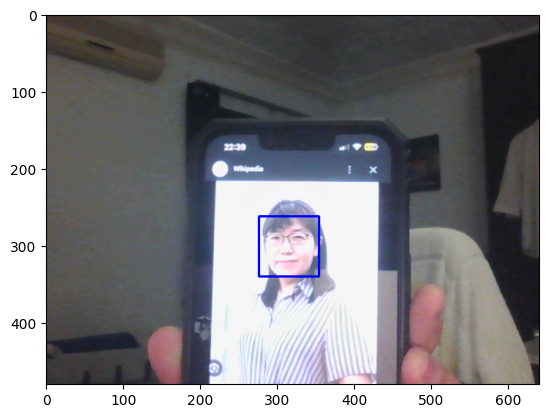

Captured 2/100 images


<Figure size 640x480 with 0 Axes>

Captured 3/100 images
Captured 4/100 images


<Figure size 640x480 with 0 Axes>

Captured 5/100 images


<Figure size 640x480 with 0 Axes>

Captured 6/100 images


<Figure size 640x480 with 0 Axes>

Captured 7/100 images


<Figure size 640x480 with 0 Axes>

Captured 8/100 images


<Figure size 640x480 with 0 Axes>

Captured 9/100 images


<Figure size 640x480 with 0 Axes>

Captured 10/100 images


<Figure size 640x480 with 0 Axes>

Captured 11/100 images


<Figure size 640x480 with 0 Axes>

Captured 12/100 images


<Figure size 640x480 with 0 Axes>

Captured 13/100 images


<Figure size 640x480 with 0 Axes>

Captured 14/100 images


<Figure size 640x480 with 0 Axes>

Captured 15/100 images


<Figure size 640x480 with 0 Axes>

Captured 16/100 images


<Figure size 640x480 with 0 Axes>

Captured 17/100 images


<Figure size 640x480 with 0 Axes>

Captured 18/100 images


<Figure size 640x480 with 0 Axes>

Captured 19/100 images


<Figure size 640x480 with 0 Axes>

Captured 20/100 images


<Figure size 640x480 with 0 Axes>

Captured 21/100 images


<Figure size 640x480 with 0 Axes>

Captured 22/100 images


<Figure size 640x480 with 0 Axes>

Captured 23/100 images


<Figure size 640x480 with 0 Axes>

Captured 24/100 images


<Figure size 640x480 with 0 Axes>

Captured 25/100 images


<Figure size 640x480 with 0 Axes>

Captured 26/100 images


<Figure size 640x480 with 0 Axes>

Captured 27/100 images


<Figure size 640x480 with 0 Axes>

Captured 28/100 images


<Figure size 640x480 with 0 Axes>

Captured 29/100 images


<Figure size 640x480 with 0 Axes>

Captured 30/100 images


<Figure size 640x480 with 0 Axes>

Captured 31/100 images


<Figure size 640x480 with 0 Axes>

Captured 32/100 images


<Figure size 640x480 with 0 Axes>

Captured 33/100 images


<Figure size 640x480 with 0 Axes>

Captured 34/100 images


<Figure size 640x480 with 0 Axes>

Captured 35/100 images


<Figure size 640x480 with 0 Axes>

Captured 36/100 images


<Figure size 640x480 with 0 Axes>

Captured 37/100 images
Captured 38/100 images


<Figure size 640x480 with 0 Axes>

Captured 39/100 images


<Figure size 640x480 with 0 Axes>

Captured 40/100 images


<Figure size 640x480 with 0 Axes>

Captured 41/100 images


<Figure size 640x480 with 0 Axes>

Captured 42/100 images


<Figure size 640x480 with 0 Axes>

Captured 43/100 images


<Figure size 640x480 with 0 Axes>

Captured 44/100 images


<Figure size 640x480 with 0 Axes>

Captured 45/100 images


<Figure size 640x480 with 0 Axes>

Captured 46/100 images


<Figure size 640x480 with 0 Axes>

Captured 47/100 images


<Figure size 640x480 with 0 Axes>

Captured 48/100 images


<Figure size 640x480 with 0 Axes>

Captured 49/100 images


<Figure size 640x480 with 0 Axes>

Captured 50/100 images


<Figure size 640x480 with 0 Axes>

Captured 51/100 images


<Figure size 640x480 with 0 Axes>

Captured 52/100 images


<Figure size 640x480 with 0 Axes>

Captured 53/100 images


<Figure size 640x480 with 0 Axes>

Captured 54/100 images


<Figure size 640x480 with 0 Axes>

Captured 55/100 images


<Figure size 640x480 with 0 Axes>

Captured 56/100 images


<Figure size 640x480 with 0 Axes>

Captured 57/100 images


<Figure size 640x480 with 0 Axes>

Captured 58/100 images


<Figure size 640x480 with 0 Axes>

Captured 59/100 images


<Figure size 640x480 with 0 Axes>

Captured 60/100 images


<Figure size 640x480 with 0 Axes>

Captured 61/100 images


<Figure size 640x480 with 0 Axes>

Captured 62/100 images


<Figure size 640x480 with 0 Axes>

Captured 63/100 images


<Figure size 640x480 with 0 Axes>

Captured 64/100 images


<Figure size 640x480 with 0 Axes>

Captured 65/100 images


<Figure size 640x480 with 0 Axes>

Captured 66/100 images


<Figure size 640x480 with 0 Axes>

Captured 67/100 images


<Figure size 640x480 with 0 Axes>

Captured 68/100 images


<Figure size 640x480 with 0 Axes>

Captured 69/100 images


<Figure size 640x480 with 0 Axes>

Captured 70/100 images


<Figure size 640x480 with 0 Axes>

Captured 71/100 images


<Figure size 640x480 with 0 Axes>

Captured 72/100 images


<Figure size 640x480 with 0 Axes>

Captured 73/100 images


<Figure size 640x480 with 0 Axes>

Captured 74/100 images


<Figure size 640x480 with 0 Axes>

Captured 75/100 images


<Figure size 640x480 with 0 Axes>

Captured 76/100 images


<Figure size 640x480 with 0 Axes>

Captured 77/100 images


<Figure size 640x480 with 0 Axes>

Captured 78/100 images


<Figure size 640x480 with 0 Axes>

Captured 79/100 images


<Figure size 640x480 with 0 Axes>

Captured 80/100 images


<Figure size 640x480 with 0 Axes>

Captured 81/100 images


<Figure size 640x480 with 0 Axes>

Captured 82/100 images


<Figure size 640x480 with 0 Axes>

Captured 83/100 images


<Figure size 640x480 with 0 Axes>

Captured 84/100 images


<Figure size 640x480 with 0 Axes>

Captured 85/100 images


<Figure size 640x480 with 0 Axes>

Captured 86/100 images
Captured 87/100 images


<Figure size 640x480 with 0 Axes>

Captured 88/100 images
Captured 89/100 images


<Figure size 640x480 with 0 Axes>

Captured 90/100 images


<Figure size 640x480 with 0 Axes>

Captured 91/100 images


<Figure size 640x480 with 0 Axes>

Captured 92/100 images


<Figure size 640x480 with 0 Axes>

Captured 93/100 images


<Figure size 640x480 with 0 Axes>

Captured 94/100 images


<Figure size 640x480 with 0 Axes>

Captured 95/100 images


<Figure size 640x480 with 0 Axes>

Captured 96/100 images


<Figure size 640x480 with 0 Axes>

Captured 97/100 images


<Figure size 640x480 with 0 Axes>

Captured 98/100 images


<Figure size 640x480 with 0 Axes>

Captured 99/100 images


<Figure size 640x480 with 0 Axes>

Captured 100/100 images


<Figure size 640x480 with 0 Axes>

Finished capturing images.
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        27
           1       1.00      1.00      1.00        23
           2       1.00      0.96      0.98        25

    accuracy                           0.99        75
   macro avg       0.99      0.99      0.99        75
weighted avg       0.99      0.99      0.99        75

[[27  0  0]
 [ 0 23  0]
 [ 1  0 24]]
Attempting to log in...
nas detected with confidence 99.78%


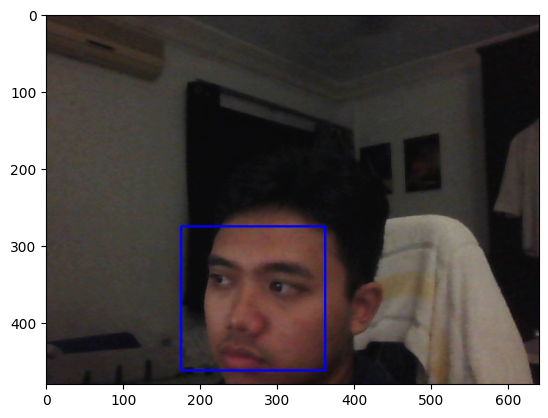

Attempting to log in...
man1 not detected


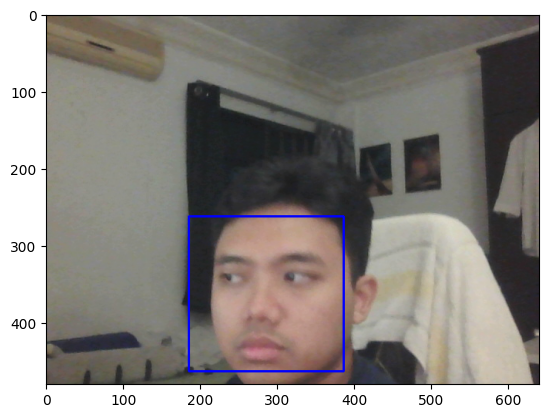

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected
man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

man1 not detected


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [43]:
def create_user():
    username = simpledialog.askstring("Input", "Enter New User Name:")
    if username:
        capture_images(username)

def app_gui():
    root = tk.Tk()
    root.title("Face Detection and Recognition System")

    create_user_btn = tk.Button(root, text="Create New User", command=create_user)
    create_user_btn.pack(pady=20)

    login_btn = tk.Button(root, text="Face ID Login", command=login_user)
    login_btn.pack(pady=20)

    train_btn = tk.Button(root, text="Train Model", command=train_model)
    train_btn.pack(pady=20)

    root.mainloop()

app_gui()
